# Spherical Array

In this notebook, we simulate a spherical array of 32 loudspeakers. Spherical harmonics are applied to beamform in 3D.

Based on Rafaely's "Fundammentals of Spherical Array Processing", we define spherical harmonics to be:
$$
    Y_n^m(\theta, \phi) = \sqrt{\frac{2n+1}{4\pi}\frac{(n-m)!}{(n+m)!}} P_n^m(\cos\theta)e^{im\phi}
$$

Before starting, you might need to install trame and some of its widgets (to display 3D graphs in jupyter). In that case, uncomment and run the following cell:

In [1]:
# !pip install trame trame-vtk trame-vuetify

In [2]:
import electroacPy as ep
from electroacPy import gtb
import numpy as np
import scipy.special
from math import factorial

import pyvista as pv
pv.set_jupyter_backend('static')

## Study
Before starting with the actual simulation setup, we can define a "spherical harmonic" function that computes weighting coefficients for each loudspeakers, based on there position on the array.

In [3]:
def sph_weight(m, n, elevation, azimuth):
    """
    Compute weights based on harmonics order (m, n) and spherical coordinates of drive units
    """
    p = scipy.special.lpmn(m, n, np.cos(elevation))
    weight = np.sqrt((2 * n + 1) / 4 / np.pi *
                     (factorial(n-m) / factorial(n+m))) * p[0][m, n] * np.exp(1j*m*azimuth)
    return weight

As for all studies, the initial step is to define which mesh is used and initialize a **loudspeakerSystem** object.

In [4]:
# get mesh file
mesh = "icosahedron_truncated.msh"

# create frequency axis and study
frequency = gtb.freqop.freq_log10(100, 8000, 25)
ico = ep.loudspeakerSystem(frequency)

Then, we define a simple unit velocity on all radiating surfaces. In the case of a truncated isocahedron geometry, 32 loudspeakers are used. 

**Keep in mind that it is a simplified study**: the actual size of loudspeakers is not taken into account; we are more interested in the implementation of spherical harmonics than the physical feasibility of this array.

In [5]:
# define loudspeaker velocity (32 drivers) - unit velocity
ico.lem_velocity("speakers", ref2bem=np.arange(1, 33))  

In [6]:
# create acoustic study
ico.study_acousticBEM("free-field", mesh, acoustic_radiator="speakers")

In [7]:
# add evaluations
ico.evaluation_sphericalRadiation("free-field", "sph", 256, radius=1)
ico.evaluation_polarRadiation("free-field", "polar_ver", -180, 180, 5, "z", "x", radius=1)

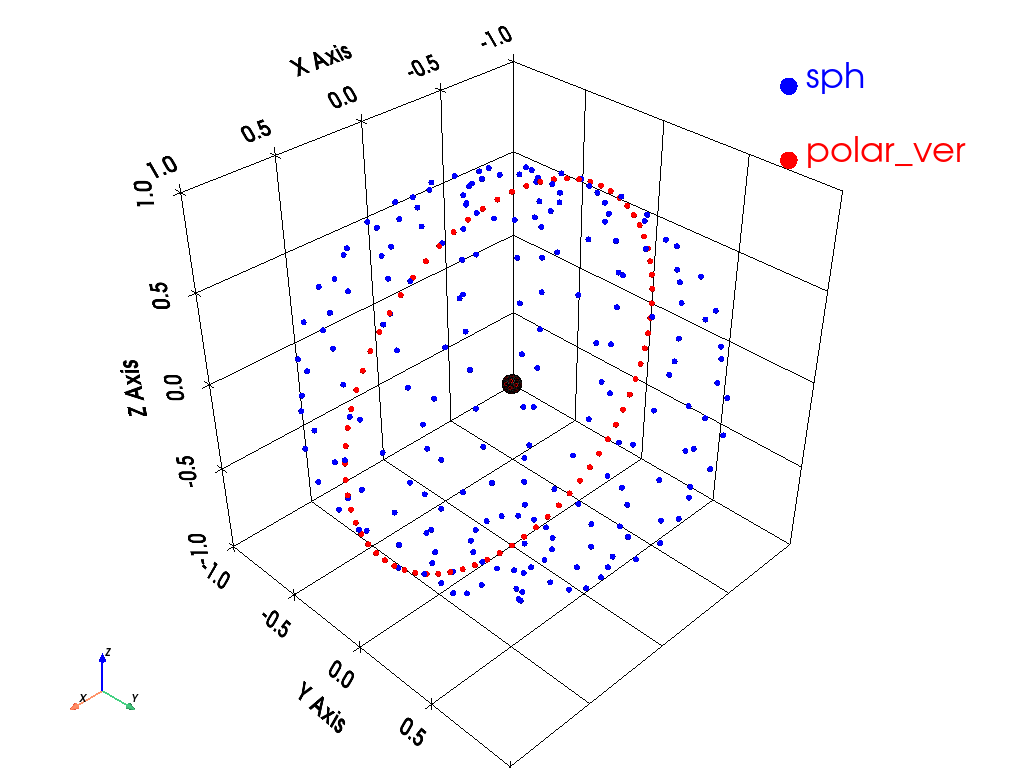

In [8]:
ico.plot_system("free-field")

As usual, the simulation is done in two steps: boundary pressure $\rightarrow$ "microphone" pressure. Uncomment the last line to save results in a sub-folder.

In [9]:
# run study
ico.run()
# ep.save("icosahedron", ico)

Computing pressure on mesh


100%|██████████████████████████████████████████| 25/25 [02:42<00:00,  6.50s/it]



Computing pressure at microphones


100%|██████████████████████████████████████████| 25/25 [01:52<00:00,  4.51s/it]


## Post-processing
To define harmonics on a sphere, we need to explicitly define the azimuth and elevation of each radiator. **The following angles were evaluated when creating the mesh.**

In [10]:
azimuth = np.deg2rad([0,                        # top speaker (facing +z)
                      180, -108, -36, 36, 108,  # first row from the top
                      0, 72, 144, -144, -72,    # second row 
                      180, -108, -36, 36, 108,  # third row
                      0,                        # bottom speaker (facing -z)
                      0, -72, -144, 144, 72,    # first row from the bottom
                      180, 108, 36, -36, -108,  # second row from the bottom
                      0, -72, -144, 144, 72])   # third row from the bottom

elevation = np.deg2rad([0,
                        37.3774, 37.3774, 37.3774, 37.3774, 37.3774,
                        63.4349, 63.4349, 63.4349, 63.4349, 63.4349,
                        79.1877, 79.1877, 79.1877, 79.1877, 79.1877,
                        180,
                        142.6226, 142.6226, 142.6226, 142.6226, 142.6226,
                        116.5651, 116.5651, 116.5651, 116.5651, 116.5651,
                        100.8123, 100.8123, 100.8123, 100.8123, 100.8123])

From these angles, we estimate the *cartesian coordinates* of all drive units:

$$
x = r \times \sin\theta \cos\phi,
$$

$$
y = r \times \sin\theta \sin\phi,
$$

$$
z = r \times \cos\theta.
$$

where $\theta$ is the elevation ($\theta=0$ faces "+z") and $\phi$ the azimuth.


In [11]:
r0 = 57.0634e-3  # radius of the spherical array
x = r0 * np.sin(elevation) * np.cos(azimuth)
y = r0 * np.sin(elevation) * np.sin(azimuth)
z = r0 * np.cos(elevation)
X = np.array([x, y, z])

The spherical beaming is done in two steps:

1. The beaming angle is set by virtually rotating the speaker array (more on that later),
2. Weighting coefficients are applied to drive units depending on the target directivity.

So, technically speaking, the beam is steered by passing translated speaker coordinates, as shown by the following figure (reference speaker in green): 

<div>
<img src="img/spherical_beamforming.png" width="700"/>
</div>

In [12]:
# Let's rotate the spherical array
theta_st = np.deg2rad(-90)  # should beam toward +90 as the angle is "reversed"
phi_st = np.deg2rad(0)

# rotate around "y" axis (elevation)
Ry = np.array([[np.cos(theta_st), 0, np.sin(theta_st)],
               [0, 1, 0],
               [-np.sin(theta_st), 0, np.cos(theta_st)]])

# rotate around "z" axis (azimuth)
Rz = np.array([[np.cos(phi_st), np.sin(phi_st), 0],
               [-np.sin(phi_st), np.cos(phi_st), 0],
               [0, 0, 1]])

# Get new coordinates
Xp = np.zeros([3, 32])
for i in range(32):
    Xp[:, i] = Ry @ Rz @ X[:, i]

# Convert cartesian coordinate back to spherical coordinates
elevation = np.arccos(Xp[2, :] / np.sqrt(Xp[0, :] ** 2 + Xp[1, :] ** 2 + Xp[2, :] ** 2))
azimuth = np.zeros(32)
for i in range(32):
    if y[i] > 0:
        azimuth[i] = np.arccos(Xp[0, i] / np.sqrt(Xp[0, i] ** 2 + Xp[1, i] ** 2))
    elif y[i] < 0:
        azimuth[i] = - np.arccos(Xp[0, i] / np.sqrt(Xp[0, i] ** 2 + Xp[1, i] ** 2))

Finally, create **filter_network** objects and apply weights to all speakers. In that specific case, we sum spherical harmonics of order O (monopole radiation) and 1 (dipole radiation) to form a cardioid directivity.

In addition to that, we use a $H_{eq}$ filter, that reduces the magnitude of the monopole radiation to match the dipole at low frequency.

<div>
<img src="img/monopole_dipole_comparison.png" width="500"/>
</div>

In [13]:
s = gtb.freqop.laplace(ico.frequency)
c = 343
Heq = (s + c / r0) * s / (s ** 2 + 2 * (c / r0) * s + 2 * (c / r0) ** 2) # equalization function
filters = ()

for i in range(32):
    w_spk = (sph_weight(0, 0, elevation[i], azimuth[i]) * Heq +
             sph_weight(0, 1, elevation[i], azimuth[i])  
             )
    filters += (w_spk, )
    ico.filter_network('drv_' + str(i + 1), ref2bem=i + 1, ref2study='free-field')
    ico.filter_addTransferFunction('drv_' + str(i + 1), 'h_sph', w_spk)

/tmp/ipykernel_493060/625749545.py:5: DeprecationWarning: `scipy.special.lpmn` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.assoc_legendre_p_all` instead.
  p = scipy.special.lpmn(m, n, np.cos(elevation))


Pressure data can be extracted from the **loudspeakerSystem** object, and the directivity can be plotted using the **gtb.plot.directivity()** method. All results can also be displayed by running the **.plot_results()** command.

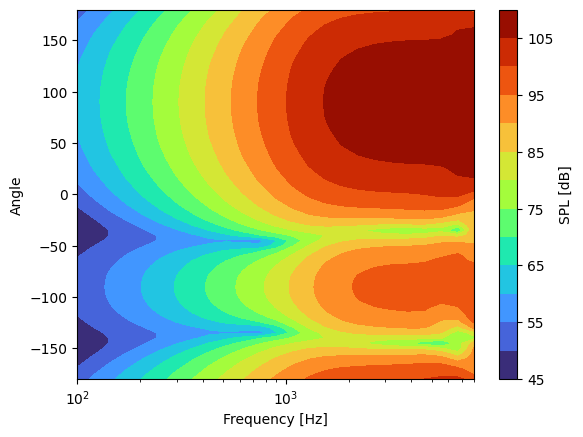

In [14]:
# Extract and plot results
# get angle of microphones
theta = ico.evaluation["free-field"].setup["polar_ver"].theta
pmic = ico.get_pMic("free-field", "polar_ver")

gtb.plot.directivity(ico.frequency, theta, pmic.T)

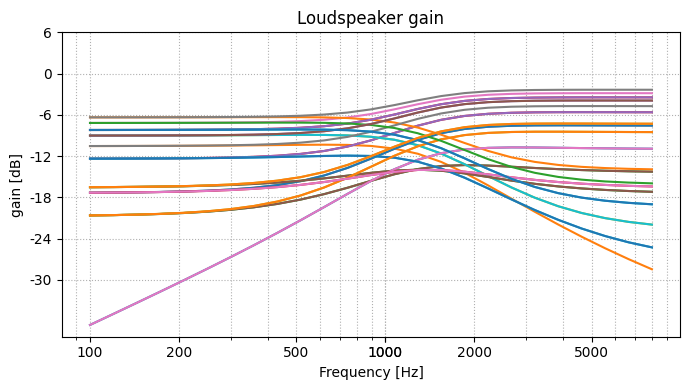

In [15]:
# plot filters
gtb.plot.FRF(ico.frequency, filters, "dB", title="Loudspeaker gain", 
             figsize=(7, 4), yticks=np.arange(6, -36, -6), 
             xticks=(100, 200, 500, 1000, 2000, 5000, 1000))

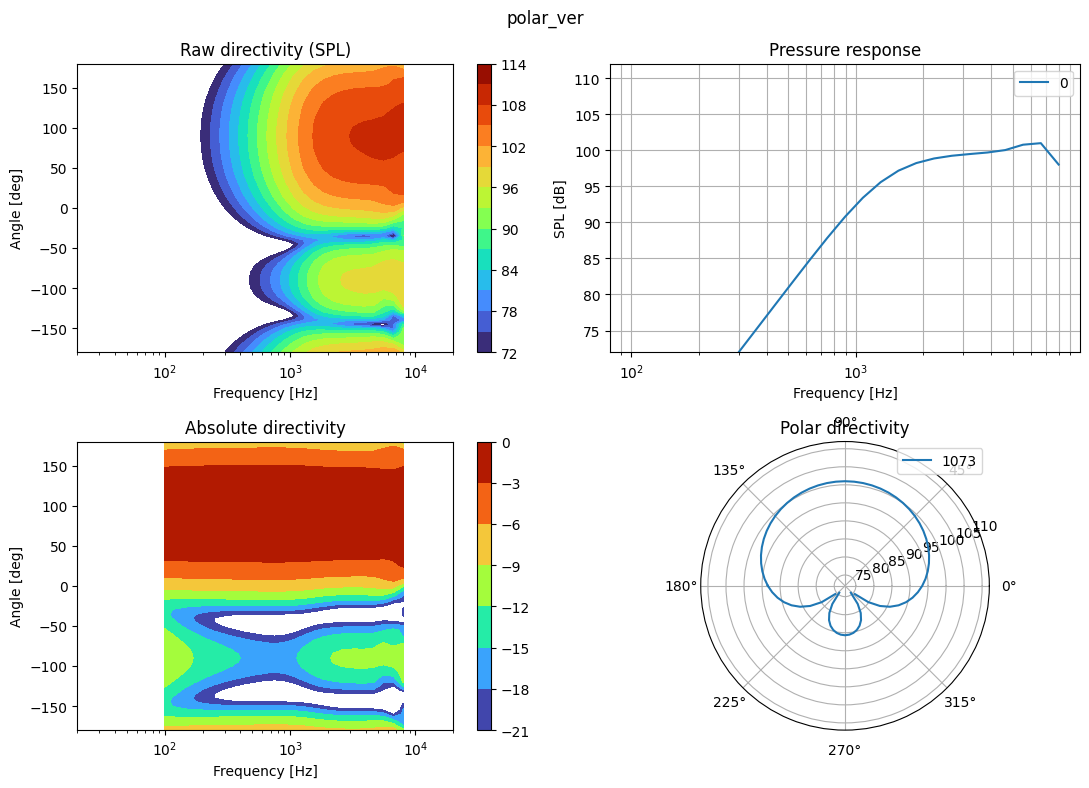

In [16]:
ico.plot_results(evaluation="polar_ver")